In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from keras import backend as K
#from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os

# Any results you write to the current directory are saved as output.

# prepare data

In [2]:
# load data

df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

In [4]:
# as shown above, THE WORLDPOST and WORLDPOST should be the same category, so merge them.

df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [5]:
# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description

# tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26


In [6]:
df.word_length.describe()

count    199914.000000
mean         29.725032
std          14.024717
min           5.000000
25%          20.000000
50%          29.000000
75%          36.000000
max         248.000000
Name: word_length, dtype: float64

In [7]:
# using 50 for padding length

maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [8]:
# category to id

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

C:\Users\sadpa\AppData\Local\Temp\ipykernel_5848\638792572.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c2id'] = df['category'].apply(lambda x: category_int[x])


# glove embedding

In [9]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 116617 unique tokens.
Total 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

# split dataset

In [11]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

# TextCNN

In [12]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11661800    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 50, 64)       12864       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 64)       19264       ['embedding[0][0]']              
                                                                                              

In [13]:
textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=20, 
                              validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 [==============================] - 24s 19ms/step - loss: 2.2463 - accuracy: 0.4146 - val_loss: 1.7241 - val_accuracy: 0.5325
Epoch 2/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.8722 - accuracy: 0.4984 - val_loss: 1.6323 - val_accuracy: 0.5525
Epoch 3/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.8025 - accuracy: 0.5144 - val_loss: 1.5938 - val_accuracy: 0.5666
Epoch 4/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7658 - accuracy: 0.5251 - val_loss: 1.5836 - val_accuracy: 0.5677
Epoch 5/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7429 - accuracy: 0.5281 - val_loss: 1.5529 - val_accuracy: 0.5741
Epoch 6/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7247 - accuracy: 0.5329 - val_loss: 1.5457 - val_accuracy: 0.5773
Epoch 7/20
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7115 - accuracy: 0.5351 - val_loss: 1.5357 -

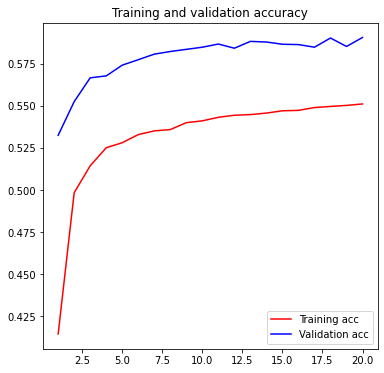

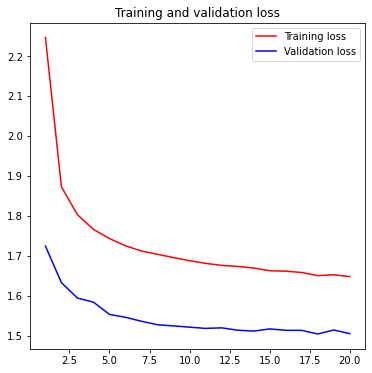

In [14]:
acc = textcnn_history.history['accuracy']
val_acc = textcnn_history.history['val_accuracy']
loss = textcnn_history.history['loss']
val_loss = textcnn_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

# Bidirectional GRU + Conv

In [15]:
# Bidrectional LSTM with convolution
# from https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

BiGRU = Model(inp, outp)
BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

BiGRU.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11661800    ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 50, 100)     0           ['embedding[1][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 256)      176640      ['spatial_dropout1d[0][0]']

In [17]:
# training

bigru_history = BiGRU.fit(x_train, 
                          y_train, 
                          batch_size=128, 
                          epochs=20, 
                          validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 [==============================] - 327s 260ms/step - loss: 1.8471 - acc: 0.5004 - val_loss: 1.4842 - val_acc: 0.5858
Epoch 2/20
1250/1250 [==============================] - 330s 264ms/step - loss: 1.5107 - acc: 0.5753 - val_loss: 1.3863 - val_acc: 0.6049
Epoch 3/20
1250/1250 [==============================] - 335s 268ms/step - loss: 1.4177 - acc: 0.5972 - val_loss: 1.3466 - val_acc: 0.6110
Epoch 4/20
1250/1250 [==============================] - 337s 270ms/step - loss: 1.3639 - acc: 0.6084 - val_loss: 1.3155 - val_acc: 0.6186
Epoch 5/20
1250/1250 [==============================] - 342s 274ms/step - loss: 1.3211 - acc: 0.6174 - val_loss: 1.2930 - val_acc: 0.6291
Epoch 6/20
1250/1250 [==============================] - 345s 276ms/step - loss: 1.2910 - acc: 0.6250 - val_loss: 1.2943 - val_acc: 0.6268
Epoch 7/20
1250/1250 [==============================] - 342s 274ms/step - loss: 1.2650 - acc: 0.6310 - val_loss: 1.2715 - val_acc: 0.6331
Epoch 8/20
1250/1250 [============

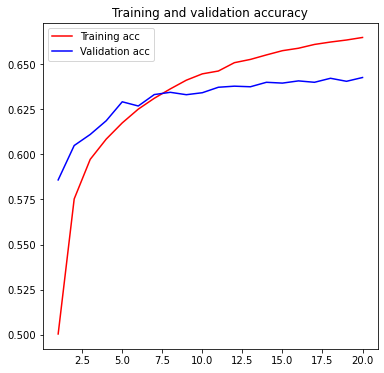

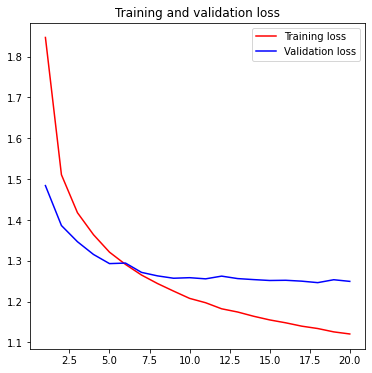

In [19]:
plt.rcParams['figure.figsize'] = (6,6)

acc = bigru_history.history['acc']
val_acc = bigru_history.history['val_acc']
loss = bigru_history.history['loss']
val_loss = bigru_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

# evaluate accuracy

In [25]:
def evaluate_accuracy(model):
    predicted = model.predict(x_val)
    diff = y_val.argmax(axis=-1) - predicted.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)

In [26]:
print("model TextCNN accuracy:          %.6f" % evaluate_accuracy(TextCNN))
print("model Bidirectional GRU + Conv:  %.6f" % evaluate_accuracy(BiGRU))


model TextCNN accuracy:          0.590551
model Bidirectional GRU + Conv:  0.642548


# Ensemble

In [27]:
def evaluate_accuracy_ensemble(models):
    res = np.zeros(shape=y_val.shape)
    for model in models:
        predicted = model.predict(x_val)
        res += predicted
    res /= len(models)
    diff = y_val.argmax(axis=-1) - res.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)

In [28]:
print(evaluate_accuracy_ensemble([TextCNN, BiGRU]))

0.6447490183327914
